# Problem 1

The dataset is available for download at https://www.kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db

## (1a)

In [1083]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dataset_raw = pd.read_csv('SpotifyFeatures.csv')
print("The dataset contains {0} songs with {1} features".format(*dataset_raw.shape))

The dataset contains 232725 songs with 18 features


## (1b)

In [1084]:
filter_genres = ['Classical', 'Pop']
filter_features = ['liveness', 'loudness']
dataset_filtered = dataset_raw[dataset_raw['genre'].isin(filter_genres)]
dataset = pd.concat([
    dataset_filtered['genre'].map(filter_genres.index),
    dataset_filtered[filter_features]
], axis=1)
dataset

,genre,liveness,loudness
104022,0,0.0762,-21.356
104023,0,0.1060,-34.255
104024,0,0.0916,-28.215
104025,0,0.1730,-37.264
104026,0,0.0858,-35.213
...,...,...,...
167297,0,0.0776,-25.477
167298,0,0.2450,-28.192
167299,0,0.0816,-25.843
167300,0,0.1050,-20.238


## (1c)

In [1085]:
training_dataset = dataset.groupby('genre').sample(frac=0.8)
validation_dataset = dataset.drop(training_dataset.index)

training_features = np.array(training_dataset.iloc[:, 1:])
training_labels = np.array(training_dataset.iloc[:, 0:1])
validation_features = np.array(validation_dataset.iloc[:, 1:])
validation_labels = np.array(validation_dataset.iloc[:, 0:1])

training_dataset, validation_dataset

(        genre  liveness  loudness
 124644      0    0.1060   -24.984
 124638      0    0.0730   -27.237
 129445      0    0.0566   -11.055
 104836      0    0.1690   -31.715
 129962      0    0.1010   -17.585
 ...       ...       ...       ...
 110785      1    0.1800    -7.807
 108023      1    0.0826    -4.440
 110262      1    0.1490    -3.887
 113176      1    0.1670    -6.490
 150113      1    0.3590    -8.962
 
 [14914 rows x 3 columns],
         genre  liveness  loudness
 104024      0    0.0916   -28.215
 104025      0    0.1730   -37.264
 104028      0    0.3340    -4.743
 104036      0    0.0583   -18.148
 104040      0    0.0972   -26.801
 ...       ...       ...       ...
 167282      0    0.1180   -17.912
 167283      0    0.0793   -36.877
 167285      0    0.3440   -23.974
 167286      0    0.0847   -29.026
 167301      0    0.0953   -29.223
 
 [3728 rows x 3 columns])

## (1d)

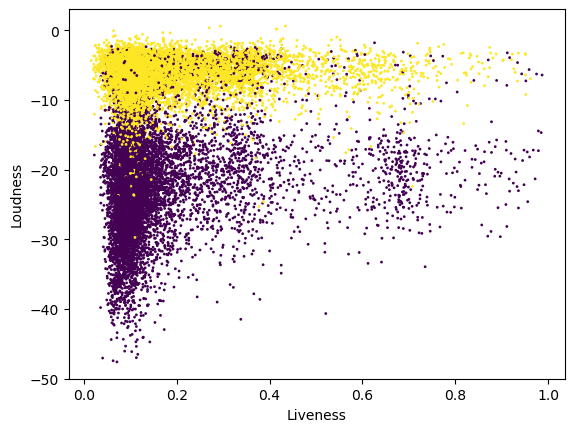

In [1086]:
plt.scatter(
    dataset['liveness'],
    dataset['loudness'],
    c=dataset['genre'],
    s=1
)
plt.xlabel('Liveness')
plt.ylabel('Loudness')
plt.show()

It looks like most classical and pop songs can be easily distinguished based on only liveness and loudness, since they for the most part form separate clusters. There are however several outliers, assuming the dataset is correctly labeled, and some mixing around liveness $= 0.1$.

# Problem 2

## (2a)

Epoch 0: loss=6333.554583531178 momentum=0.0
Epoch 1000: loss=1566.342559718898 momentum=0.0007249518722602932
Epoch 2000: loss=1313.923909588905 momentum=0.00045714798271490054
Epoch 3000: loss=1200.6187463967146 momentum=0.00032821577805686175
Epoch 4000: loss=1137.814724127528 momentum=0.00025426960555829936
Epoch 5000: loss=1098.3205395751518 momentum=0.00020676068721980911
Epoch 6000: loss=1071.3484472822056 momentum=0.0001738008550096204
Epoch 7000: loss=1051.8321552963073 momentum=0.00014964702861641754
Epoch 8000: loss=1037.0959405190317 momentum=0.00013120861150950347
Epoch 9000: loss=1025.599599309537 momentum=0.00011668226687078231
Epoch 10000: loss=1016.3963347421453 momentum=0.00010494777487402018
Epoch 11000: loss=1008.8731999460848 momentum=9.527374416018475e-05
Epoch 12000: loss=1002.6164281801559 momentum=8.716292209509646e-05
Epoch 13000: loss=997.3369073404749 momentum=8.026570960639745e-05
Epoch 14000: loss=992.8266987107429 momentum=7.432928005002282e-05
Epoch 1500

Text(0, 0.5, 'Loss')

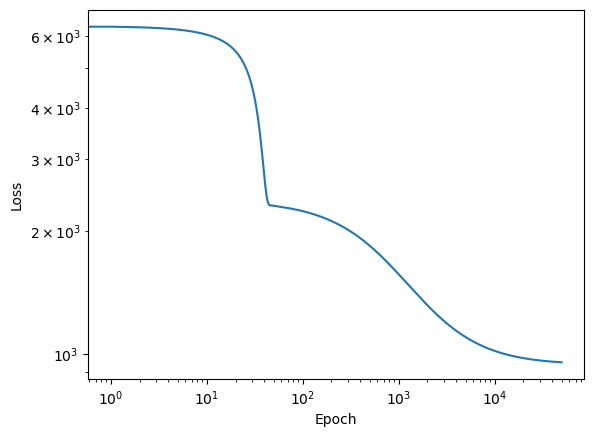

In [1095]:
num_epochs = 50001
step_size = 1e-2
beta = .5

num_features = training_features.shape[1]
num_training_samples = len(training_labels)

weights = np.random.normal(size=(num_features, 1))
biases = np.random.normal(size=(1, 1))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

losses = []
prev_weights = weights
prev_biases = biases

for epoch in range(num_epochs):
    # Ideally, we'd use cross-entropy loss, but I was curious about how MSE would perform
    predictions = sigmoid(training_features @ weights + biases)
    error = predictions - training_labels
    loss = np.sum(error ** 2)
    losses.append(loss)

    # TODO: stochastic

    grad = 2 * error * predictions * (1 - predictions)
    grad_weights = 1 / num_training_samples * (training_features.T @ grad)
    grad_biases = 1 / num_training_samples * np.sum(grad)

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: loss={loss} momentum={(biases - prev_biases)[0, 0]}")

    momentum_weights = beta * (weights - prev_weights)
    momentum_biases = beta * (biases - prev_biases)
    prev_weights = np.copy(weights)
    prev_biases = np.copy(biases)

    weights += -step_size * grad_weights + momentum_weights
    biases += -step_size * grad_biases + momentum_biases

plt.plot(range(num_epochs), losses)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')

A larger `step_size` results in fewer epochs spent searching for a steeper decline, but with too large steps it can overshoot and be unable to fall into a smaller pocket. Adding momentum allows larger steps without having to sacrifice finer movements, since the momentum depends on the previous step size and thus the gradient. That said, there's now two knobs to tweak instead of one and tuning these hyper parameters can still be a finicky process.

## (2b)

In [1088]:
predictions = sigmoid(validation_features @ weights + biases)
num_incorrect = np.sum(np.abs(np.rint(predictions) - validation_labels))
print(f"The model correctly predicts ~{(1 - num_incorrect / len(validation_labels)) * 100:.1f}% of the samples in the validation dataset")

predictions = sigmoid(training_features @ weights + biases)
num_incorrect = np.sum(np.abs(np.rint(predictions) - training_labels))
print(f"The model correctly predicts ~{(1 - num_incorrect / len(training_labels)) * 100:.1f}% of the samples in the training dataset")

The model correctly predicts ~92.8% of the samples in the validation dataset
The model correctly predicts ~92.6% of the samples in the training dataset


Some difference between the training and validation set prediction accuracy is expected, and since the validation accuracy is roughly on par with the training accuracy, we can be reasonably confident that the model hasn't overfit on the training data. Overfitting with only 3 model parameters is probably unlikely anyway.

## (2c)

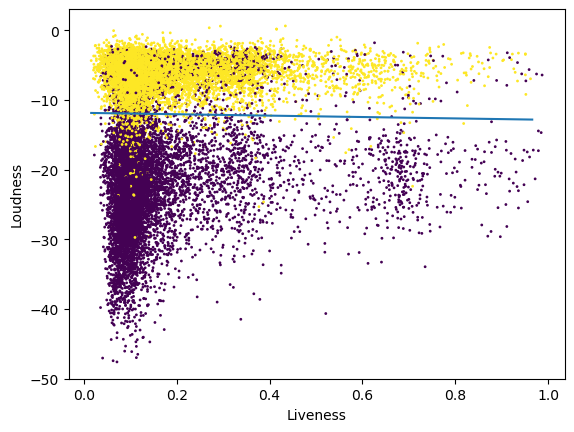

In [1089]:
plt.scatter(
    dataset['liveness'],
    dataset['loudness'],
    c=dataset['genre'],
    s=1
)
plt.xlabel('Liveness')
plt.ylabel('Loudness')

x = np.arange(np.min(dataset['liveness']), np.max(dataset['liveness']), .05)
y = (-biases - x * weights[1, 0]) / weights[1, 0]
plt.plot(x, y[0])
plt.show()

The plot above shows the "decision boundary", where the model gives an equal probability for each genre, as a line on top of the loudness vs. liveness plot, showing that the regression has found a fairly decent boundary.

# Problem 3

## (3a)

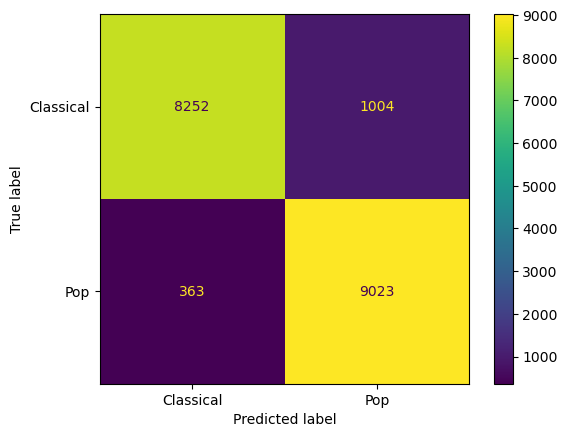

In [1090]:
ground_truths = np.array(dataset['genre'])
raw_predictions = sigmoid(np.array(dataset.iloc[:, 1:]) @ weights + biases)
predictions = np.rint(raw_predictions).astype(np.int32)[:, 0]

confusion_matrix = np.zeros((2, 2), dtype=np.int32)
for truth, prediction in zip(ground_truths, predictions):
    confusion_matrix[truth, prediction] += 1

from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix, display_labels=filter_genres)
disp.plot()
plt.show()

The confusion matrix for the complete dataset shows that the model accurately predicts most of the songs correctly, with a small portion of songs incorrectly predicted as classical, and an even smaller portion incorrectly predicted as pop.

## (3b)

The confusion matrix makes it easier to see which genre the model struggles with more. We can see that a larger portion of classical songs are incorrectly predicted to be pop songs than vice versa.

## (3c)

In [1091]:
max_suggestions = 15
pop_index = filter_genres.index('Pop')
dataset_with_predictions = dataset_filtered.copy()
dataset_with_predictions['predicted_genre'] = predictions
dataset_with_predictions['raw_prediction'] = raw_predictions
dataset_with_predictions = dataset_with_predictions[
    (dataset_with_predictions.genre == 'Classical') &
    (dataset_with_predictions.predicted_genre == pop_index)
]
dataset_with_predictions.sort_values(
    by=['raw_prediction'], ascending=False, inplace=True)
dataset_with_predictions.head(max_suggestions)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,predicted_genre,raw_prediction
127261,Classical,Richie Kotzen,Go Faster,7qLq9x0er8eP04MIaxwK0Y,43,0.133000,0.504,175773,0.939,0.007580,C,0.6260,-1.786,Minor,0.0554,118.090,4/4,0.741,1,0.923104
130662,Classical,Ancient Bards,Through My Veins,5ZaPLI4eUmxw6l8eQAWTkO,40,0.000079,0.290,439640,0.982,0.000000,G,0.3160,-2.358,Major,0.0841,90.131,4/4,0.366,1,0.910102
129624,Classical,Conquering Dystopia,Ashes of Lesser Men,09F9ERsvgwC4Kel6f9VAX1,29,0.000006,0.440,335282,0.987,0.881000,A,0.0596,-2.304,Major,0.1290,134.984,4/4,0.257,1,0.908936
167266,Classical,Queensrÿche,Resistance - Remastered/2003,7IYKTl0Jhz9T8u4etdq37C,29,0.013500,0.452,290667,0.989,0.000631,A,0.1340,-2.349,Major,0.1670,129.922,4/4,0.200,1,0.908692
124574,Classical,Queensrÿche,Another Rainy Night (Without You) - Remastered...,4tUma2etb9HVEHTeIdJjl3,42,0.091700,0.462,269373,0.955,0.000138,A,0.3690,-2.456,Minor,0.0645,96.930,4/4,0.324,1,0.908622
128731,Classical,Andy James,Obsession,6d3hYluFN9nyRpPdU9EHxC,32,0.000014,0.382,219035,0.955,0.164000,C#,0.3250,-2.544,Minor,0.0673,104.990,4/4,0.295,1,0.906455
105305,Classical,Queensrÿche,I Don't Believe In Love - Remastered 2003,0U2TocFjqul3sis3sE5jZl,53,0.037300,0.562,263560,0.991,0.000011,G,0.4250,-2.654,Major,0.0745,118.004,4/4,0.266,1,0.905101
125635,Classical,Queensrÿche,Revolution Calling - Remastered 2003,0GoQdU4T7AwJrrhE1WKFww,40,0.047300,0.571,279827,0.991,0.000037,D,0.2190,-2.569,Major,0.0667,123.954,4/4,0.295,1,0.904983
127708,Classical,Andy James,Afterlife,2YPuZOOm5w7ynLK4hvU1WN,34,0.000200,0.335,252085,0.938,0.458000,D,0.3520,-2.664,Minor,0.0673,145.043,4/4,0.287,1,0.904227
126771,Classical,Andy James,Equinox,5rkoaupq70zo2EDfg1kpp1,36,0.000073,0.372,228464,0.917,0.005360,A,0.3730,-2.717,Minor,0.0768,129.969,4/4,0.146,1,0.903312


As mentioned in 3b, classical songs are more difficult to classify for this particular model. The table above shows the top 15 classical songs which the model incorrectly classified as pop, ordered by prediction confidence from high to low.